Steps in Windows:
pip install -r requirements-tf.txt
pip install causalml[tf]
pip install -U numpy
pip install duecredit

In [2]:
!which python

/d/InstalledSoftware/anaconda3/envs/python-notebook/python


In [5]:
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import BaseRRegressor
from xgboost import XGBRegressor
from causalml.dataset import synthetic_data

y, X, treatment, _, _, e = synthetic_data(mode=1, n=1000, p=5, sigma=1.0)

lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

nn = MLPTRegressor(hidden_layer_sizes=(10, 10),
                 learning_rate_init=.1,
                 early_stopping=True,
                 random_state=42)
te, lb, ub = nn.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Neural Network (MLP)): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub = xl.estimate_ate(X, treatment, y, e)
print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

rl = BaseRRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub =  rl.estimate_ate(X=X, p=e, treatment=treatment, y=y)
print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Linear Regression): 0.75 (0.60, 0.90)
Average Treatment Effect (XGBoost): 0.69 (0.62, 0.76)
Average Treatment Effect (Neural Network (MLP)): 0.42 (0.29, 0.55)
Average Treatment Effect (BaseXRegressor using XGBoost): 0.63 (0.59, 0.68)
Average Treatment Effect (BaseRRegressor using XGBoost): 0.84 (0.83, 0.84)


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
from causalml.inference.meta import LRSRegressor
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

In [8]:
import causalml
print(causalml.__version__)

0.13.0


In [9]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

In [10]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

# After calling estimate_ate, add pretrain=True flag to skip training
# This flag is applicable for other meta learner
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y, pretrain=True)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

(array([0.69876296]), array([0.65131118]), array([0.74621474]))
ATE estimate: 0.699
ATE lower bound: 0.651
ATE upper bound: 0.746
(array([0.69876296]), array([0.65131118]), array([0.74621474]))
ATE estimate: 0.699
ATE lower bound: 0.651
ATE upper bound: 0.746


In [11]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

Using the ready-to-use XGBTRegressor class
(array([0.53986422]), array([0.51427417]), array([0.56545426]))

Using the BaseTRegressor class and using XGB (same result):
(array([0.53986422]), array([0.51427417]), array([0.56545426]))

Using the BaseTRegressor class and using Linear Regression (different result):
(array([0.68171009]), array([0.64082839]), array([0.72259178]))


In [12]:
# X Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(learner=XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseXRegressor class and using XGB:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('\nUsing the BaseXRegressor class and using Linear Regression:')
print(ate_x)

Using the BaseXRegressor class and using XGB:
(array([0.50311158]), array([0.4803748]), array([0.52584836]))

Using the BaseXRegressor class and using Linear Regression:
(array([0.68171009]), array([0.64082839]), array([0.72259178]))


In [13]:
# X Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_x = BaseXRegressor(XGBRegressor())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseXRegressor class and using XGB without propensity score input:')
print(ate_x)

# Calling the Base Learner class and feeding in LinearRegression
learner_x = BaseXRegressor(learner=LinearRegression())
ate_x = learner_x.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseXRegressor class and using Linear Regression without propensity score input:')
print(ate_x)

Using the BaseXRegressor class and using XGB without propensity score input:
(array([0.50548362]), array([0.48273389]), array([0.52823334]))

Using the BaseXRegressor class and using Linear Regression without propensity score input:
(array([0.68171009]), array([0.64082839]), array([0.72259178]))


In [14]:
# R Learner with propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e)
print('Using the BaseRRegressor class and using Linear Regression:')
print(ate_r)

Using the BaseRRegressor class and using XGB:
(array([0.50355363]), array([0.50308403]), array([0.50402323]))
Using the BaseRRegressor class and using Linear Regression:
(array([0.50705106]), array([0.50663428]), array([0.50746783]))


In [15]:
# R Learner with propensity score input and random sample weight
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
sample_weight = np.random.randint(1, 3, len(y))
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y, p=e, sample_weight=sample_weight)
print('Using the BaseRRegressor class and using XGB:')
print(ate_r)

Using the BaseRRegressor class and using XGB:
(array([0.52325914]), array([0.52278555]), array([0.52373273]))


In [16]:
# R Learner without propensity score input
# Calling the Base Learner class and feeding in XGB
learner_r = BaseRRegressor(learner=XGBRegressor())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using XGB without propensity score input:')
print(ate_r)

# Calling the Base Learner class and feeding in LinearRegression
learner_r = BaseRRegressor(learner=LinearRegression())
ate_r = learner_r.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the BaseRRegressor class and using Linear Regression without propensity score input:')
print(ate_r)

Using the BaseRRegressor class and using XGB without propensity score input:
(array([0.47276786]), array([0.4722993]), array([0.47323643]))
Using the BaseRRegressor class and using Linear Regression without propensity score input:
(array([0.58234583]), array([0.5819298]), array([0.58276186]))


In [17]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y)

# R Learner with propensity score input 
learner_r = BaseRRegressor(learner=XGBRegressor())
cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=treatment, y=y)

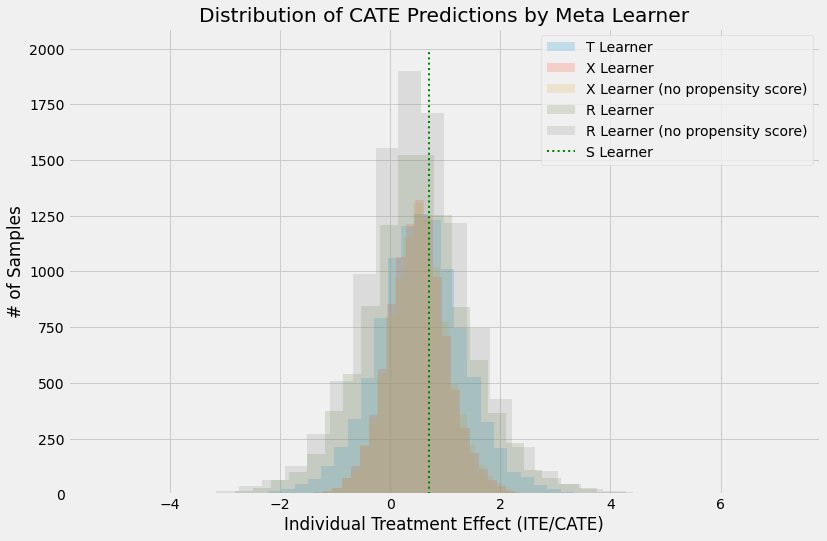

In [18]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')
plt.vlines(cate_s[0], 0, plt.axes().get_ylim()[1], label='S Learner',
           linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

In [19]:
train_summary, validation_summary = get_synthetic_summary_holdout(simulate_nuisance_and_easy_treatment,
                                                                  n=10000,
                                                                  valid_size=0.2,
                                                                  k=10)

In [20]:
train_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.374386,0.077316,3.776245
S Learner (XGB),0.085260,0.097212,0.294656
T Learner (LR),0.355322,0.035464,0.314248
T Learner (XGB),0.067269,0.582446,0.986749
X Learner (LR),0.355322,0.035464,0.314248
X Learner (XGB),0.040757,0.266136,0.573377
R Learner (LR),0.294828,0.036660,0.310595
R Learner (XGB),0.153346,0.834499,1.107285


In [21]:
validation_summary

,Abs % Error of ATE,MSE,KL Divergence
Actuals,0.000000,0.000000,0.000000
S Learner (LR),0.379092,0.078715,3.872674
S Learner (XGB),0.084098,0.090567,0.300103
T Learner (LR),0.354265,0.035212,0.336952
T Learner (XGB),0.066309,0.377294,0.798032
X Learner (LR),0.354265,0.035212,0.336952
X Learner (XGB),0.033720,0.193696,0.439185
R Learner (LR),0.292916,0.036668,0.332533
R Learner (XGB),0.157955,0.532139,0.889330


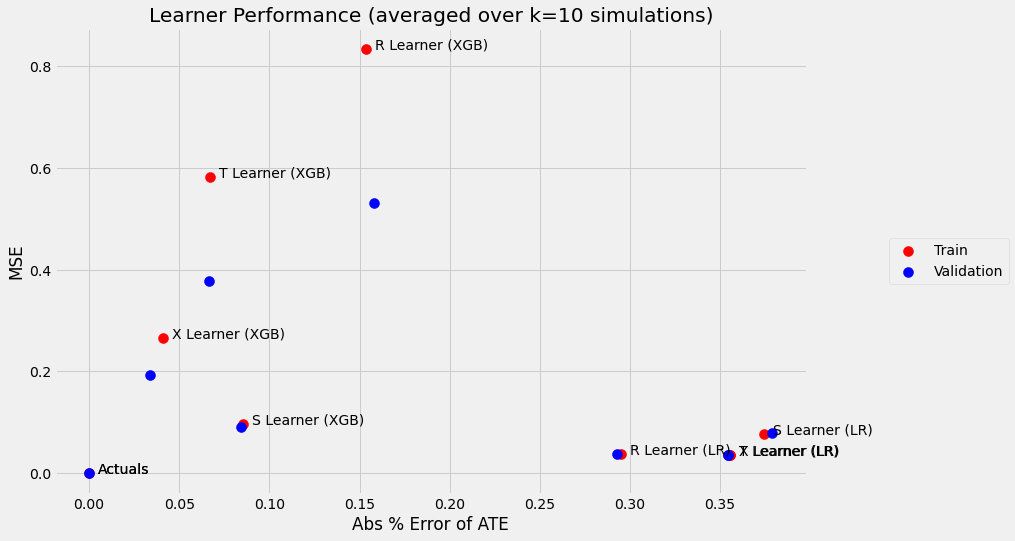

In [22]:
scatter_plot_summary_holdout(train_summary,
                             validation_summary,
                             k=10,
                             label=['Train', 'Validation'],
                             drop_learners=[],
                             drop_cols=[])

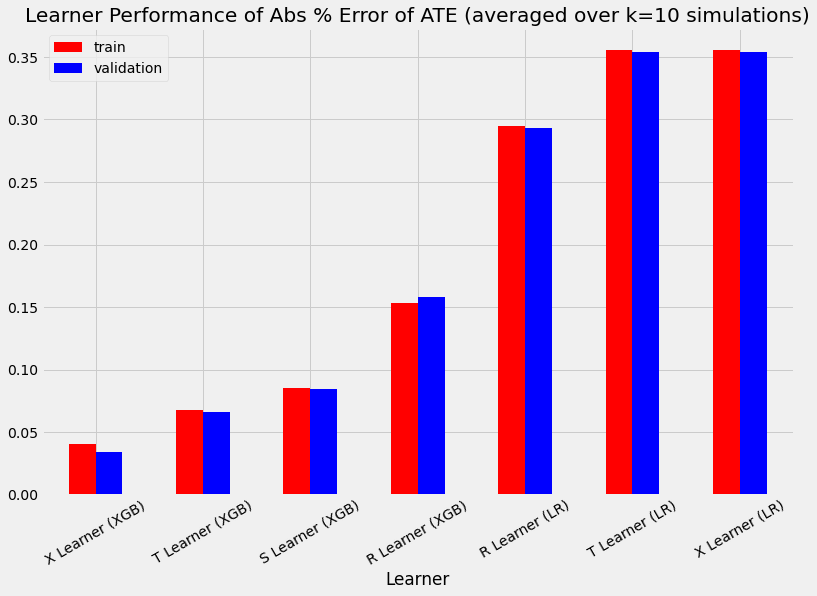

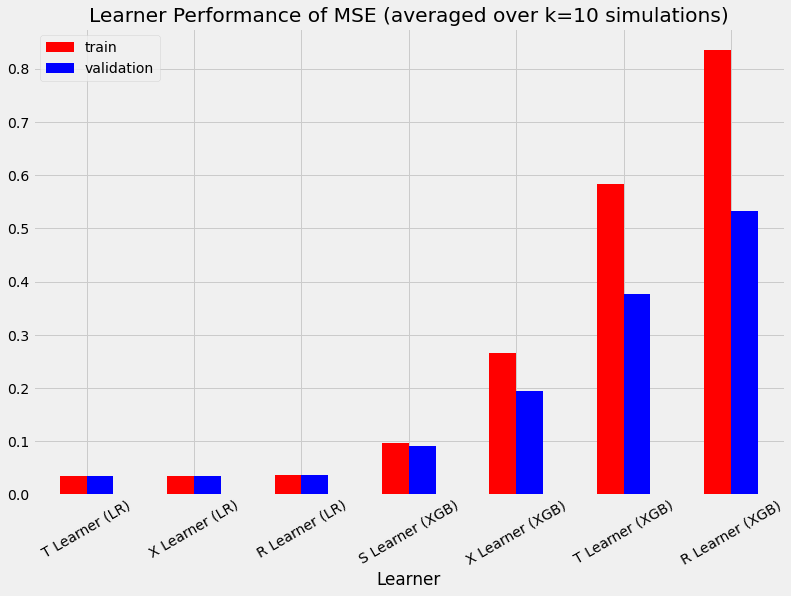

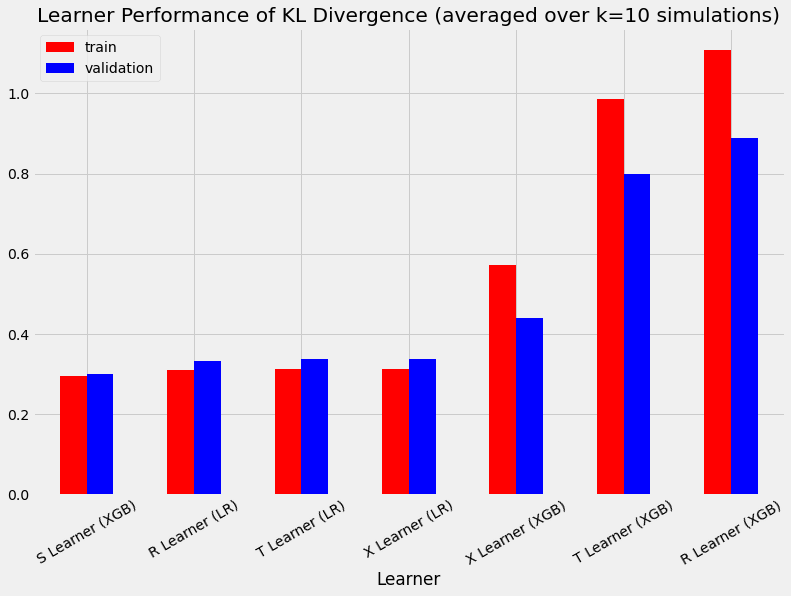

In [23]:
bar_plot_summary_holdout(train_summary,
                         validation_summary,
                         k=10,
                         drop_learners=['S Learner (LR)'],
                         drop_cols=[])

In [24]:
# Single simulation
train_preds, valid_preds = get_synthetic_preds_holdout(simulate_nuisance_and_easy_treatment,
                                                       n=50000,
                                                       valid_size=0.2)

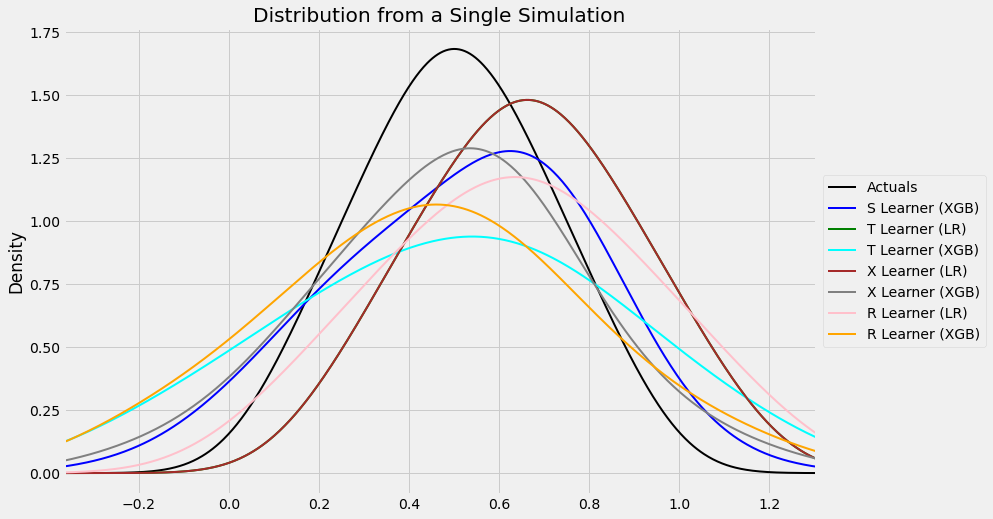

In [25]:
#distribution plot for signle simulation of Training
distr_plot_single_sim(train_preds, kind='kde', linewidth=2, bw_method=0.5,
                      drop_learners=['S Learner (LR)',' S Learner (XGB)'])

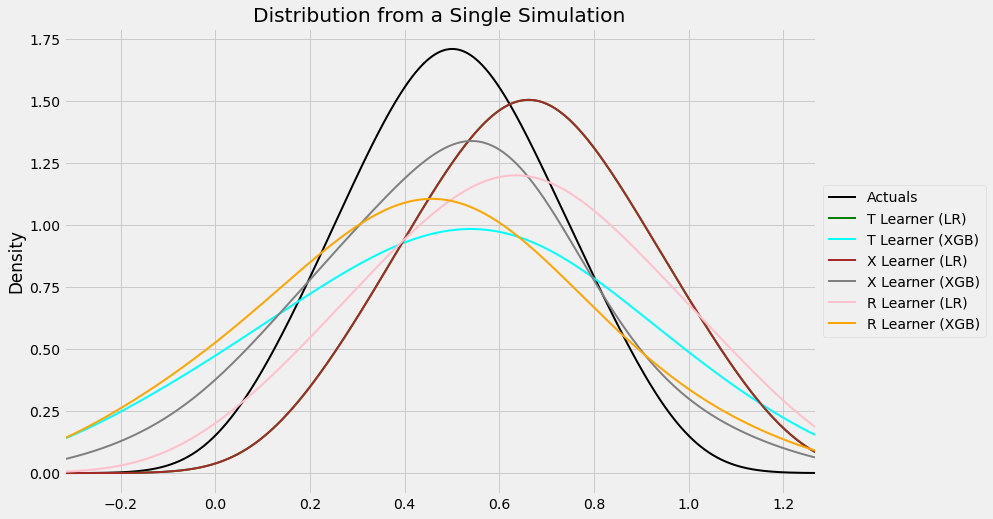

In [26]:
#distribution plot for signle simulation of Validaiton
distr_plot_single_sim(valid_preds, kind='kde', linewidth=2, bw_method=0.5,
                      drop_learners=['S Learner (LR)', 'S Learner (XGB)'])

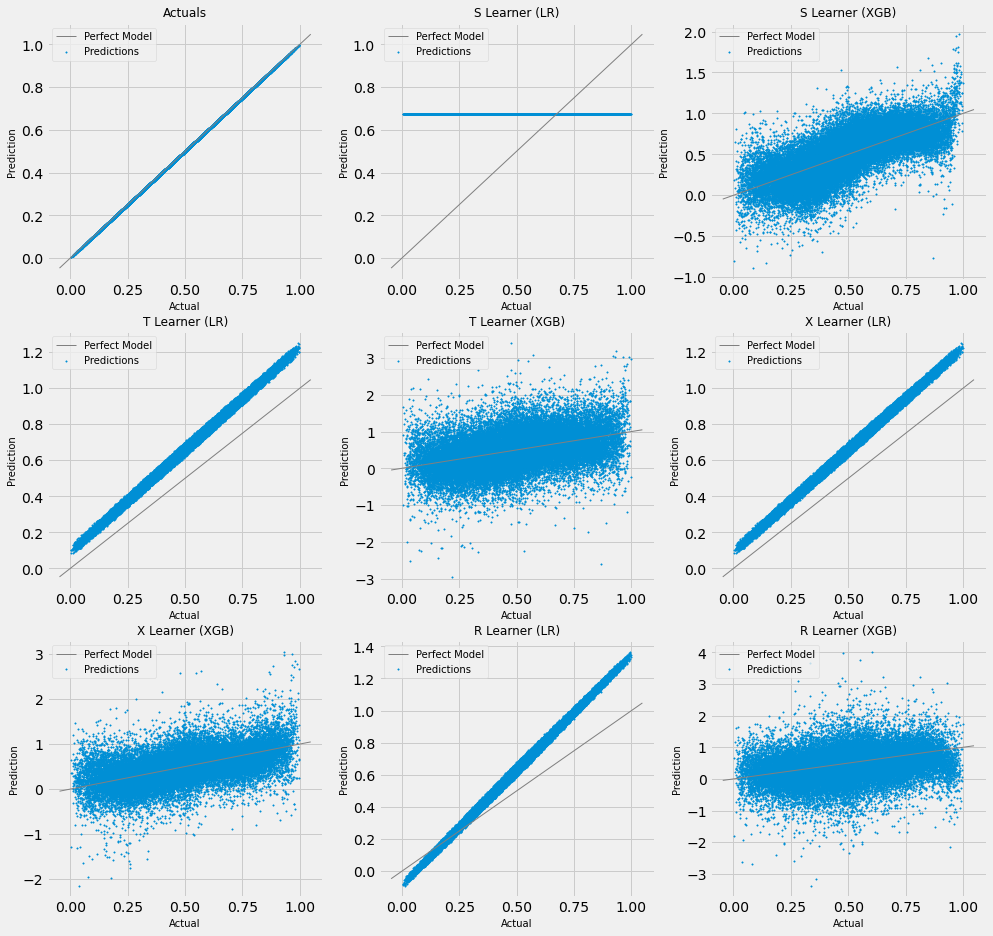

In [27]:
# Scatter Plots for a Single Simulation of Training Data
scatter_plot_single_sim(train_preds)

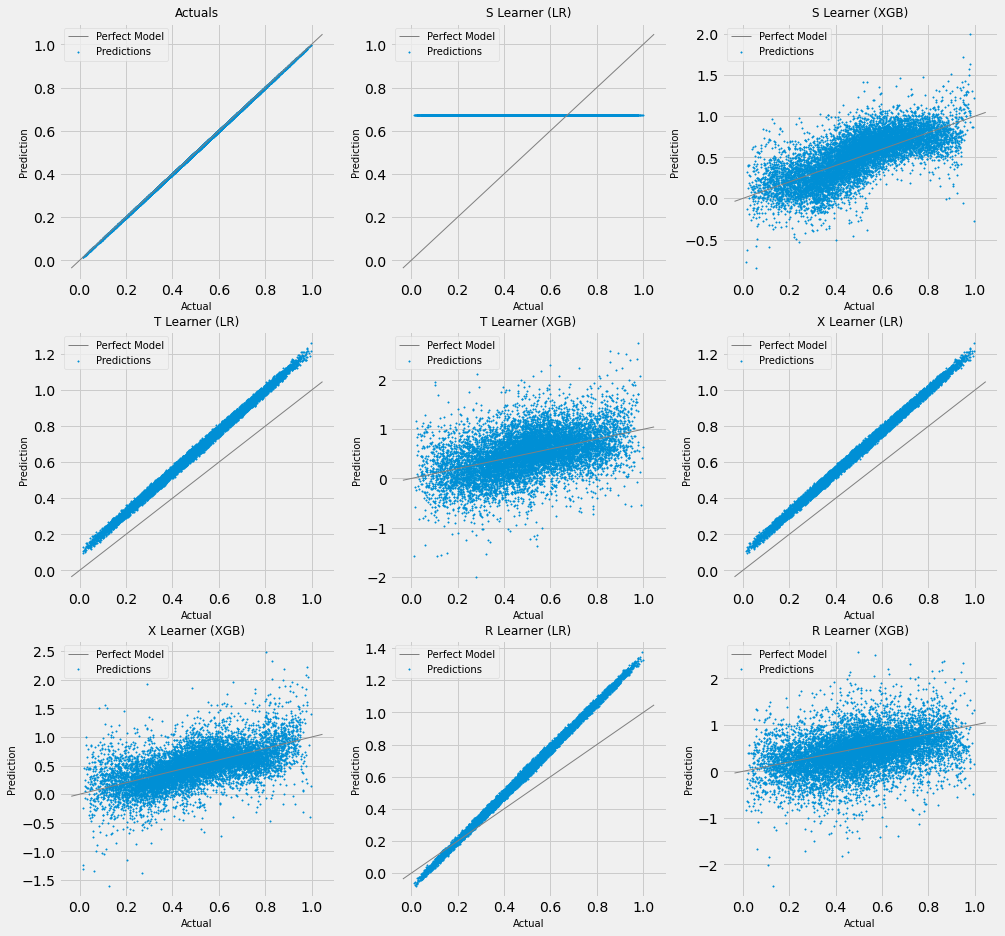

In [28]:
# Scatter Plots for a Single Simulation of Validaiton Data
scatter_plot_single_sim(valid_preds)

,Learner,cum_gain_auuc
0,Actuals,4.934257e+06
6,R Learner (LR),4.932891e+06
2,T Learner (LR),4.932250e+06
4,X Learner (LR),4.932250e+06
1,S Learner (XGB),4.702493e+06
5,X Learner (XGB),4.549321e+06
3,T Learner (XGB),4.417380e+06
7,R Learner (XGB),4.357599e+06
8,Random,4.005400e+06


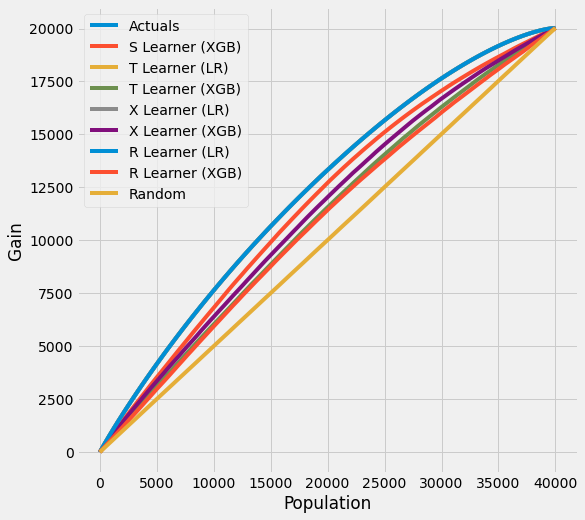

In [29]:
# Cumulative Gain AUUC values for a Single Simulation of Training Data
get_synthetic_auuc(train_preds, drop_learners=['S Learner (LR)'])

,Learner,cum_gain_auuc
0,Actuals,307386.170637
6,R Learner (LR),307299.079325
2,T Learner (LR),307256.991995
4,X Learner (LR),307256.991995
1,S Learner (XGB),292551.957467
5,X Learner (XGB),284475.827444
3,T Learner (XGB),277570.247417
7,R Learner (XGB),273651.691953
8,Random,250231.343509


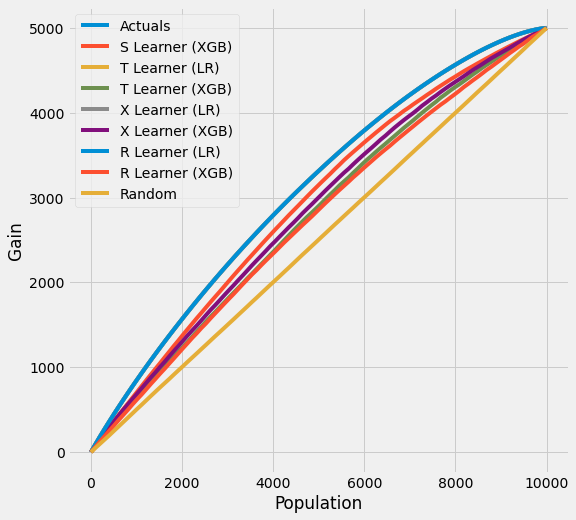

In [30]:
# Cumulative Gain AUUC values for a Single Simulation of Validaiton Data
get_synthetic_auuc(valid_preds, drop_learners=['S Learner (LR)'])